$ datasets download genome taxon 2559587 --filename Riboviria-clad-virus-2559587.zip

datasets --api-key 222e331106a08414fef34a705ed4b8038408 download genome taxon 2559587 --filename Riboviria-clad-virus-2559587.zip
Collecting 16,015 genome accessions [================================================] 100% 16015/16015
Downloading: Riboviria-clad-virus-2559587.zip    564kB 36.9kB/s

In [1]:
import NCBIDataset as nds
import KmerVectors as kvec
from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
PTH="../../../../data/na_read/"
TAX_PATH="../../../../data/ncbi/genome/taxonomy/"
TAX_VIRUS_PATH="../../../../data/ncbi/genome/taxonomy/Viruses_10239/"

#!ls -al $TAX_VIRUS_PATH

adnaviria_dir    = TAX_VIRUS_PATH + "Adnaviria_2840022/"
bamfordvirae_dir = TAX_VIRUS_PATH + "Bamfordvirae_2732005/Nucleocytoviricota_2732007/Pokkesviricetes_2732525/Chitovirales_2732527/Poxviridae_10240/Orthopoxvirus_10242/"
riboviria_dir    = TAX_VIRUS_PATH + "Riboviria_2559587/Orthornavirae_2732396/Pisuviricota_2732408/Pisoniviricetes_2732506/Nidovirales_76804/Cornidovirineae_2499399/Coronaviridae_11118/Orthocoronavirinae_2501931/"
#"Riboviria_2559587/"

adnaviria_dataset    = adnaviria_dir     + "ncbi_dataset.zip"   #
bamfordvirae_dataset = bamfordvirae_dir  + "ncbi_dataset.zip"   # pox
riboviria_dataset    = riboviria_dir     + "ncbi_dataset.zip"   # sars-cov2

In [3]:
adnaviria_nds = nds.NCBIDataset('adnaviria', adnaviria_dataset)
adnaviria_nds.dataset_summary()

bamfordvirae_nds = nds.NCBIDataset('bamfordvirae', bamfordvirae_dataset)
bamfordvirae_nds.dataset_summary()

riboviria_nds = nds.NCBIDataset('riboviria', riboviria_dataset)
riboviria_nds.dataset_summary()

dataset name: [adnaviria]
# fna/fna2 files Total:  [103]
# fna cds_from_genomic files: [39]
# fna2 genomic files :  [64]
# gff files:  [39]
# faa files:  [39]
{
  "name": "INSDC Submitter",
  "releaseDate": "2001-11-06",
  "stats": {
    "geneCounts": {
      "proteinCoding": 73,
      "total": 73
    }
  }
}
1	Sulfolobus islandicus filamentous virus: 2
2	Captovirus AFV1: 2
3	Sulfolobus islandicus rod-shaped virus 1: 2
4	Sulfolobus islandicus rod-shaped virus 2: 2
5	Acidianus rod-shaped virus 1: 2
...	...
32	Sulfolobales Beppu filamentous phage 1: 1
33	Acidianus rod-shaped virus 3: 1
34	Metallosphaera rod-shaped virus 1: 1
35	Saccharolobus solfataricus rod-shaped virus 1: 1
36	Pyrobaculum filamentous virus 2: 1
dataset name: [bamfordvirae]
# fna/fna2 files Total:  [810]
# fna cds_from_genomic files: [324]
# fna2 genomic files :  [486]
# gff files:  [324]
# faa files:  [324]
{
  "name": "INSDC Submitter",
  "releaseDate": "2002-04-16",
  "stats": {
    "geneCounts": {
      "proteinCodi

In [4]:
kv = kvec.KmerVectors(['A','G','C','T'], 6, [bamfordvirae_nds, riboviria_nds])
print(kv.labels)
d = kv.seq2KmerSentences('fna2', base_count_max=4, length_min=10000)

KmerVectors Object -
alphabet [['A', 'G', 'C', 'T']]
dict: [['AAAAAA', 'AAAAAG', 'AAAAAC', 'AAAAAT']]...[['TTTTTA', 'TTTTTG', 'TTTTTC', 'TTTTTT']]
Labels: [{'bamfordvirae': 1, 'riboviria': 2}]
[bamfordvirae]
[../../../../data/ncbi/genome/taxonomy/Viruses_10239/Bamfordvirae_2732005/Nucleocytoviricota_2732007/Pokkesviricetes_2732525/Chitovirales_2732527/Poxviridae_10240/Orthopoxvirus_10242/ncbi_dataset.zip]
dataset name: [bamfordvirae]
   fna/fna2 files Total:  [810]
   fna cds_from_genomic files: [324]
   fna2 genomic files :  [486]
   gff files:  [324]
   faa files:  [324]
class labels: [{'bamfordvirae': 1, 'riboviria': 2}]
[riboviria]
[../../../../data/ncbi/genome/taxonomy/Viruses_10239/Riboviria_2559587/Orthornavirae_2732396/Pisuviricota_2732408/Pisoniviricetes_2732506/Nidovirales_76804/Cornidovirineae_2499399/Coronaviridae_11118/Orthocoronavirinae_2501931/ncbi_dataset.zip]
dataset name: [riboviria]
   fna/fna2 files Total:  [496]
   fna cds_from_genomic files: [227]
   fna2 genomic 

In [16]:
df=pd.DataFrame(data=d)
df

,v1,v2
0,bamfordvirae,TAGTAA AGTAAA GTAAAA TAAAAT AAAATT AAATTA AATT...
1,bamfordvirae,CACGAC ACGACT CGACTG GACTGT ACTGTA CTGTAG TGTA...
2,bamfordvirae,AAGCAC AGCACT GCACTC CACTCA ACTCAT CTCATT TCAT...
3,bamfordvirae,AAGCAC AGCACT GCACTC CACTCA ACTCAT CTCATT TCAT...
4,bamfordvirae,GACTCC ACTCCA CTCCAT TCCATC CCATCA CATCAG ATCA...
...,...,...
667,riboviria,GACAAA ACAAAG CAAAGC AAAGCT AAGCTG AGCTGA GCTG...
668,riboviria,AGTAAA GTAAAG TAAAGT AAAGTG AAGTGA AGTGAG GTGA...
669,riboviria,CGGGTT GGGTTT GGTTTT GTTTTT TTTTTT TTTTTG TTTT...
670,riboviria,ACTTTT CTTTTA TTTTAA TTTAAA TTAAAG TAAAGT AAAG...


/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Samples by Label')

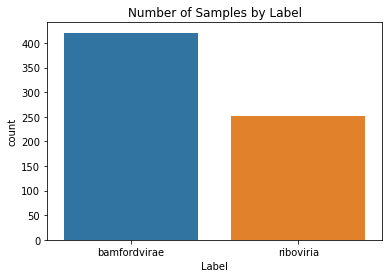

In [6]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of Samples by Label')

* Create input and output vectors.
* Process the labels.

In [7]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [9]:
max_words = 5000
max_len = 10000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN
Define the RNN structure.

In [20]:
#tf.keras.layers.Embedding(
#    input_dim,
#    output_dim,
#    embeddings_initializer="uniform",
#    embeddings_regularizer=None,
#    activity_regularizer=None,
#    embeddings_constraint=None,
#    mask_zero=False,
#    input_length=None,
#    **kwargs
#)
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,5000,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

2022-08-09 21:36:28.306654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10000)]           0         
                                                                 
 embedding (Embedding)       (None, 10000, 50)         250000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Fit on the training data.

In [21]:
#model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss')])

Epoch 1/10
4/4 [==============================] - 84s 21s/step - loss: 0.0640 - accuracy: 1.0000 - val_loss: 0.3044 - val_accuracy: 0.9304
Epoch 2/10
4/4 [==============================] - 83s 21s/step - loss: 0.1256 - accuracy: 0.9956 - val_loss: 0.0787 - val_accuracy: 1.0000


In [22]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [23]:
accr = model.evaluate(test_sequences_matrix,Y_test)

4/4 [==============================] - 3s 665ms/step - loss: 0.0574 - accuracy: 1.0000


In [24]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.057
  Accuracy: 1.000


Test sets

|Time|Loss|Accuracy|
|-|-|-|
|2022-08-09|0.462|0.822|